# ロジスティック回帰で予測するサンプル

In [3]:
import pandas as pd
import numpy as np

import re

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
df = pd.read_csv('./datasets/titanic/train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [6]:
test_df = pd.read_csv('./datasets/titanic/test.csv')
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 名前の前処理family name, last nameに分割

In [7]:
title_pattern = re.compile('[a-zA-Z]+\.\s')
LAST='LastName'
FAMILY='FamilyName'

def _preprocess_name(df: pd.DataFrame) -> pd.DataFrame:
    name_df = df['Name'].str.split(',', expand=True)
    name_df.columns = [LAST, FAMILY]
    name_df[FAMILY] = name_df[FAMILY].str.replace(title_pattern, '', regex=True).str.strip()
    df = df.drop(columns='Name')
    name_df = name_df.drop(columns='LastName')
    return pd.concat([df, name_df], axis=1)

## pclassの前処理 欠損埋めしてスケーリング

In [8]:
PCLASS= 'Pclass'

def _preprocess_pclass(df: pd.DataFrame) -> pd.DataFrame:
    df[PCLASS] = df[PCLASS].fillna(0)
    
    scaler = MinMaxScaler()
    scaler.fit(df[[PCLASS]])
    
    df[PCLASS] = scaler.transform(df[[PCLASS]])
    return df
    

## Age, Fareの前処理　欠損埋めしてスケーリング

In [9]:
AGE = 'Age'
FARE = 'Fare'
SIBSP = 'SibSp'
PARCH = 'Parch'


def _preprocess_age_and_fare_sibsp_parch(df: pd.DataFrame) -> pd.DataFrame:
    df['Age_isnull'] = df[AGE].isnull().astype(int)
    df['Fare_isnull'] = df[FARE].isnull().astype(int)
    
    mean_age = df[AGE].mean()
    mean_fare = df[FARE].mean()
    
    df[AGE] = df[AGE].fillna(mean_age)
    df[FARE] = df[FARE].fillna(mean_fare)
    df[SIBSP] = df[SIBSP].fillna(0)
    df[PARCH] = df[PARCH].fillna(0)
    
    scaler = StandardScaler()
    scaler.fit(df[[AGE, FARE, SIBSP, PARCH]])
    
    df[[AGE, FARE, SIBSP, PARCH]] = scaler.transform(df[[AGE, FARE, SIBSP, PARCH]])
    return df
    
    

In [10]:
def _preprocess_sex_cabin_embarked(df: pd.DataFrame) -> pd.DataFrame:
    dummy_df = pd.get_dummies(df, drop_first=True, dummy_na=True, columns=['Sex', 'Cabin', 'Embarked'])
    return dummy_df

In [11]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=['PassengerId', 'Ticket', 'Name'])

    # df = _preprocess_name(df)
    df = _preprocess_pclass(df)
    df = _preprocess_age_and_fare_sibsp_parch(df)
    df = _preprocess_sex_cabin_embarked(df)
    return df

In [12]:
prep_df = preprocess(df)

In [13]:
prep_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Age_isnull,Fare_isnull,Sex_male,Sex_nan,...,Cabin_F E57,Cabin_F G63,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_nan,Embarked_Q,Embarked_S,Embarked_nan
count,418.000000,418.000000,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,418.000000,418.000000,418.000000,418.0,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0
mean,0.363636,0.632775,3.187243e-17,-1.593622e-17,-2.974760e-17,-1.806104e-17,0.205742,0.002392,0.636364,0.0,...,0.002392,0.002392,0.002392,0.002392,0.004785,0.002392,0.782297,0.110048,0.645933,0.0
std,0.481622,0.420919,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,0.404727,0.048912,0.481622,0.0,...,0.048912,0.048912,0.048912,0.048912,0.069088,0.048912,0.413179,0.313324,0.478803,0.0
min,0.000000,0.000000,-2.385419e+00,-4.994700e-01,-4.002477e-01,-6.387815e-01,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,-5.763018e-01,-4.994700e-01,-4.002477e-01,-4.972129e-01,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,0.000000e+00,-4.994700e-01,-4.002477e-01,-3.796234e-01,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0
75%,1.000000,1.000000,4.340463e-01,6.169924e-01,-4.002477e-01,-7.399887e-02,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0
max,1.000000,1.000000,3.623577e+00,8.432229e+00,8.781044e+00,8.547081e+00,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## 25%でhold-outしてバリデーションデータを作成

In [16]:
from sklearn.model_selection import train_test_split

# ① 学習用データとバリデーションデータを用意
df_x = prep_df.drop(columns=['Survived'])
df_y = prep_df['Survived']

train_x, valid_x, train_y, valid_y = train_test_split(df_x, df_y, test_size=0.25, random_state=42)

## 学習

In [17]:
model = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=100, verbose=1)
model.fit(train_x, train_y)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           89     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16955D+02    |proj g|=  9.85000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   89     27     31      1     0     0   2.459D-04   3.189D+01
  F =   31.889843772751068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(random_state=42, verbose=1)

In [122]:
import warnings
warnings.filterwarnings('ignore')

train_losses = []
validation_losses = []

iteration = 50
model = LogisticRegression(penalty=None, C=1.0, random_state=42, max_iter=1, warm_start=True)

for i in range(iteration):
    model.fit(train_x, train_y)
    
    y_pred_train = model.predict_proba(train_x)
    y_pred = model.predict_proba(valid_x)
    logloss_train = log_loss(y_true=train_y, y_pred=y_pred_train)
    logloss_valid = log_loss(y_true=valid_y, y_pred=y_pred)
    
    train_losses.append(logloss_train)
    validation_losses.append(logloss_valid)

train_losses = np.array(train_losses)
validation_losses = np.array(validation_losses)

In [123]:
validation_losses = np.array([v if i < 15 else v + i * 0.001 for i, v in enumerate(validation_losses)])

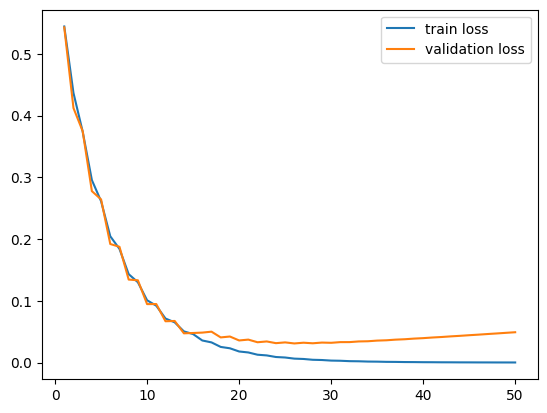

In [125]:
from matplotlib import pyplot as plt

x = [i + 1 for i in range(iteration)]
plt.plot(x, train_losses, label='train loss')
plt.plot(x, validation_losses, label='validation loss')
plt.legend(loc='upper right')

## バリデーションデータで評価

In [18]:
from sklearn.metrics import log_loss

In [19]:
y_pred_train = model.predict_proba(train_x)
y_pred = model.predict_proba(valid_x)

logloss_train = log_loss(y_true=train_y, y_pred=y_pred_train)
logloss_valid = log_loss(y_true=valid_y, y_pred=y_pred)

In [20]:
print(f"logloss - train: {logloss_train}")
print(f"logloss - valid: {logloss_valid}")

logloss - train: 0.04036900626364433
logloss - valid: 0.04127559383485853


In [29]:
import joblib
joblib.dump(model, 'model.joblib')

model = joblib.load('model.joblib')
m2

LogisticRegression(random_state=42, verbose=1)

In [239]:
prep_test_df = preprocess(test_df)

In [241]:
model.predict_proba(prep_test_df)

array([[0.9572391 , 0.0427609 ],
       [0.07326137, 0.92673863],
       [0.95779246, 0.04220754],
       [0.97403959, 0.02596041],
       [0.06271273, 0.93728727],
       [0.97299447, 0.02700553],
       [0.0440171 , 0.9559829 ],
       [0.96706166, 0.03293834],
       [0.06272682, 0.93727318],
       [0.96973778, 0.03026222],
       [0.97854889, 0.02145111],
       [0.9710821 , 0.0289179 ],
       [0.04430376, 0.95569624],
       [0.97282266, 0.02717734],
       [0.04933349, 0.95066651],
       [0.05474413, 0.94525587],
       [0.95411408, 0.04588592],
       [0.97006411, 0.02993589],
       [0.06912948, 0.93087052],
       [0.06770571, 0.93229429],
       [0.96390624, 0.03609376],
       [0.97075553, 0.02924447],
       [0.07341629, 0.92658371],
       [0.95895374, 0.04104626],
       [0.02743257, 0.97256743],
       [0.9741376 , 0.0258624 ],
       [0.03975551, 0.96024449],
       [0.97019564, 0.02980436],
       [0.96762124, 0.03237876],
       [0.97215463, 0.02784537],
       [0.

joblib                   1.2.0
